# COVID-19 Severity Scoring from Chest X-rays using Deep Learning

In [1]:

!pip install opencv-python scikit-learn pandas matplotlib seaborn tensorflow keras tqdm


In [2]:

import os
import cv2
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [5]:

metadata = pd.read_excel("Metadata.xlsx")
metadata_clean = metadata.dropna(subset=['Filename', 'Consensus score'])
print("Metadata loaded. Valid entries:", len(metadata_clean))
metadata.head()


Metadata loaded. Valid entries: 1364


,Dataset,Filename,Score R,Score D,Consensus score,Poor quality D,Poor quality R,Subset,Label
0,Actualmed-COVID-chestxray-dataset,DX.1.2.840.113564.1722810162.20200327160432430...,3.0,4.0,3.5,No,No,Training,COVID-19
1,Actualmed-COVID-chestxray-dataset,CR.1.2.840.113564.1722810170.20200327151518468...,1.0,5.0,3.0,No,No,Training,COVID-19
2,Actualmed-COVID-chestxray-dataset,CR.1.2.840.113564.1722810170.20200321181200328...,2.0,4.0,3.0,No,No,Training,COVID-19
3,Actualmed-COVID-chestxray-dataset,CR.1.2.840.113564.1722810170.20200407121512859...,5.0,NaN,5.0,Yes,No,Training,COVID-19
4,Actualmed-COVID-chestxray-dataset,DX.1.2.840.113564.1722810162.20200324122608185...,6.0,6.0,6.0,No,No,Training,COVID-19


In [9]:
import os
import zipfile

zip_path = "COVID Chest X-Ray Dataset.zip"
extract_path = "COVID_Dataset"

# Step 1: Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(" Extraction complete.")

# Step 2: Traverse deeper to find actual image files
for root, dirs, files in os.walk(extract_path):
    if files:
        print("Root:", root)
        print("Files (first 5):", files[:5])
        break


 Extraction complete.
Root: COVID_Dataset/covid-chestxray-dataset/ann
Files (first 5): ['865336ed.jpg.json', '16706_1_1.png.json', '3b46de94.jpg.json', '19073f37.jpg.json', 'nejmc2001573_f1b.jpeg.json']


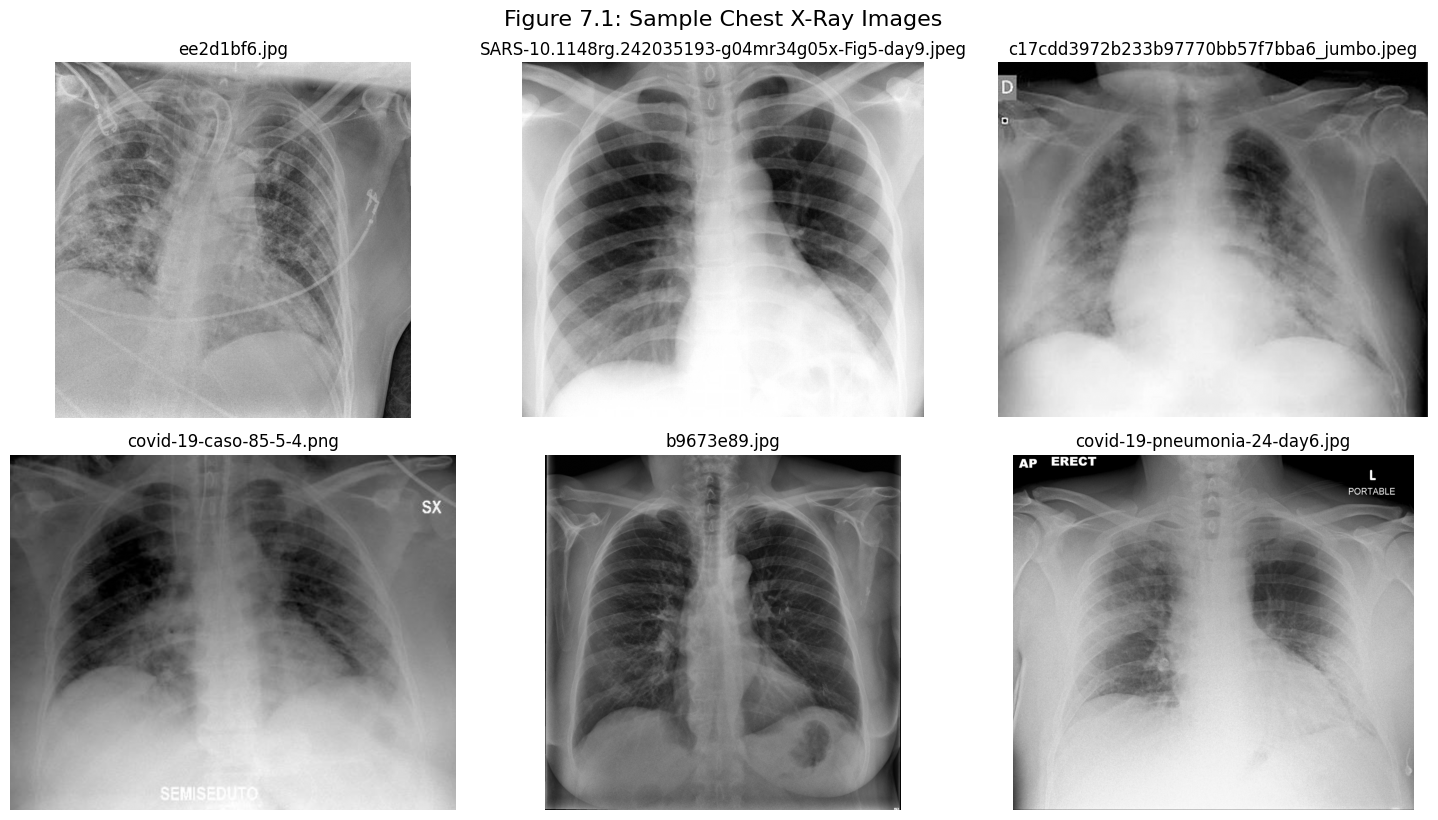

In [10]:
import os
import cv2
import matplotlib.pyplot as plt

# Path to images
img_dir = "COVID_Dataset/covid-chestxray-dataset/img"
image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Show first 6 images
plt.figure(figsize=(15, 8))

for i, file in enumerate(image_files[:6]):
    img_path = os.path.join(img_dir, file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(file)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Figure 7.1: Sample Chest X-Ray Images", fontsize=16, y=1.02)
plt.show()


In [7]:

def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (224, 224))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    normalized = enhanced_img / 255.0
    return np.expand_dims(normalized, axis=-1)

def find_image_path(filename, root_folder):
    for sub in ['img', 'masks_human', 'masks_machine']:
        candidate = os.path.join(root_folder, sub, filename)
        if os.path.exists(candidate):
            return candidate
    return None

def load_images(root_folder, metadata_df):
    X, y = [], []
    for _, row in metadata_df.iterrows():
        filename = str(row['Filename']).strip()
        score = float(row['Consensus score'])
        img_path = find_image_path(filename, root_folder)
        if img_path:
            img = apply_clahe(img_path)
            if img is not None:
                X.append(img)
                y.append(score)
    return np.array(X), np.array(y)


In [11]:

dataset_root = "COVID_Dataset/covid-chestxray-dataset"
X, y = load_images(dataset_root, metadata_clean)
print("Images loaded:", X.shape, "Labels:", y.shape)


Images loaded: (398, 224, 224, 1) Labels: (398,)


In [12]:

def build_model(base='resnet'):
    input_tensor = Input(shape=(224, 224, 1))
    x = tf.keras.layers.Concatenate()([input_tensor, input_tensor, input_tensor])
    if base == 'resnet':
        base_model = ResNet50(include_top=False, input_tensor=x, weights='imagenet')
    else:
        base_model = DenseNet121(include_top=False, input_tensor=x, weights='imagenet')
    x = GlobalAveragePooling2D()(base_model.output)
    output = Dense(1, activation='linear')(x)
    model = Model(inputs=input_tensor, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='mse')
    return model


In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
maes, rmses, pccs = [], [], []

# Stratify on integer severity scores
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y.astype(int))):
    print(f"\n Fold {fold + 1}")

    model = build_model('densenet')  # or 'resnet'

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3)
    ]

    model.fit(X_train, y_train, validation_split=0.1, epochs=5, batch_size=32,
              callbacks=callbacks, verbose=0)

    preds = model.predict(X_test).flatten()

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))  #  Manually take sqrt
    pcc, _ = pearsonr(y_test, preds)

    maes.append(mae)
    rmses.append(rmse)
    pccs.append(pcc)

    print(f"MAE: {mae:.3f}, RMSE: {rmse:.3f}, PCC: {pcc:.3f}")



 Fold 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step
MAE: 6.159, RMSE: 6.370, PCC: 0.459

 Fold 2


2/3 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step
MAE: 3.112, RMSE: 3.401, PCC: 0.631

 Fold 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step
MAE: 2.370, RMSE: 2.829, PCC: 0.475

 Fold 4
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step
MAE: 6.124, RMSE: 6.350, PCC: 0.437

 Fold 5
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step
MAE: 7.259, RMSE: 7.433, PCC: 0.498


In [17]:

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(img_array, axis=0))
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_3010']]
Received: inputs=Tensor(shape=(1, 224, 224, 1))
  warnings.warn(msg)


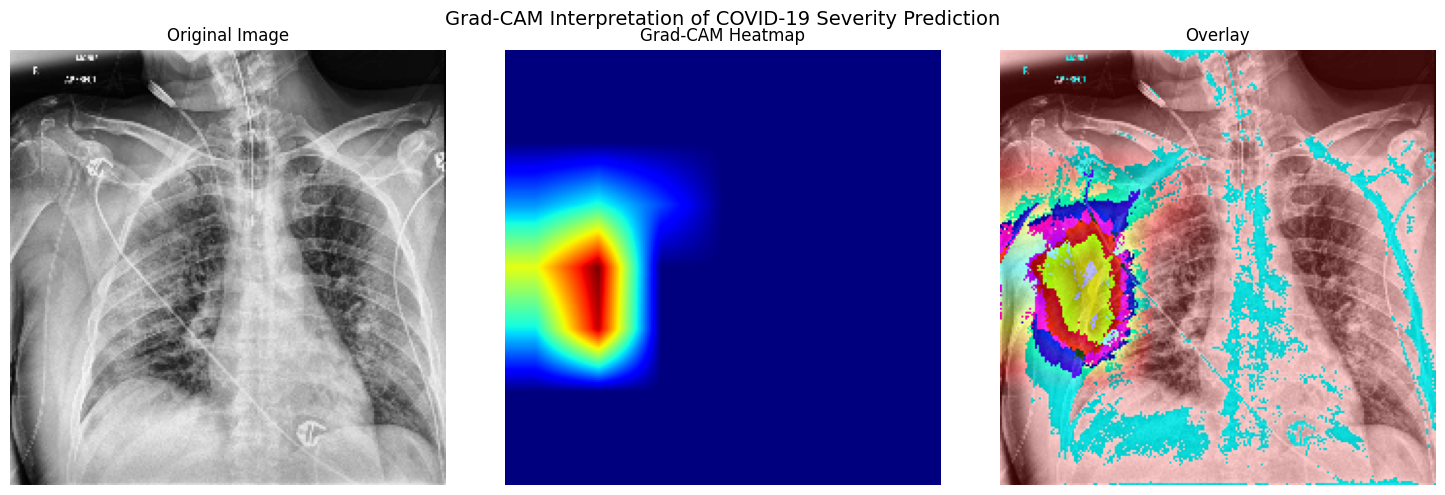

In [18]:

# -----------------------------
# Step 2: Choose a test image
# -----------------------------
test_image = X_test[0]  # Replace with any test image
original_image = test_image.squeeze()

# -----------------------------
# Step 3: Generate heatmap
# -----------------------------
last_conv_layer = 'conv5_block16_2_conv'  # Last conv layer in DenseNet121
heatmap = make_gradcam_heatmap(test_image, model, last_conv_layer)

# -----------------------------
# Step 4: Visualize Grad-CAM
# -----------------------------
# Resize heatmap to image size
heatmap_resized = cv2.resize(heatmap, (224, 224))

# Apply colormap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Overlay heatmap on original image
overlay = heatmap_colored * 0.4 + np.uint8(original_image * 255)[..., np.newaxis]

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap_resized, cmap='jet')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Overlay")
plt.imshow(overlay.astype('uint8'))
plt.axis('off')

plt.suptitle("Grad-CAM Interpretation of COVID-19 Severity Prediction", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:

model.save("covid_severity_model.h5")
print("Model saved!")
